# cis-pQTL analysis of APOL1_olink in UKB AFR samples

In [1]:
#load modules:
import pandas as pd
import numpy as np
import time as tm
import os
import dxdata
from matplotlib import pyplot as plt
import seaborn as sns
from bgen import BgenReader
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [2]:
import tensorqtl
from tensorqtl import cis
import subprocess
from scipy import stats
def inverse_normal_transform(M):
    adjustment = 3/8
    r = stats.rankdata(M)
    return pd.Series(stats.norm.ppf((r - adjustment) / (M.shape[0] + 1 - 2 * adjustment)), index=M.index, name=M.name)

## Using genotype data
First we are going to do association + fine-mapping in genotype data (i.e. not exome data).
(Although at the end we will find that the results are consistent)

In [127]:
#Read the full genotype data:
fn = "/mnt/project/qsw/resources/ppp_afr_expression_mat_naincluded.tsv.gz"
d = pd.read_csv(fn, sep="\t", index_col=0)
apol1 = d["OID30708"]
apol1.dropna(inplace=True)
sample_names = apol1.index.astype(int)
fn = "/mnt/project/Bulk/Imputation/UKB imputation from genotype/ukb22828_c22_b0_v3.sample"
sns = pd.read_csv(fn, sep=" ")
sns = sns.iloc[1:,:]
sns.set_index("ID_1", inplace=True, drop=False)
sns.index = sns.index.astype(int)
sns["idx"] = np.arange(sns.shape[0])
touse_idx = sns.loc[sample_names,"idx"]
touse_samples = sns.loc[sample_names,"ID_1"]
fn = "/mnt/project/Bulk/Imputation/UKB imputation from genotype/ukb22828_c22_b0_v3.bgen"
bfile = BgenReader(fn)
left = 36649056 - 10**5
right = 36663576 + 10**5
variants = bfile.fetch('22', left, right)
cisvars_g = []
dosages_g = []
pos_g = []
alleles_g = []
cnt = 0
for v in variants:
    dos = pd.Series(v.alt_dosage[touse_idx])
    if sum(dos[~dos.isna()])>4:
        cisvars_g.append(v.varid)
        dosages_g.append(dos)
        pos_g.append(v.pos)
        alleles_g.append(v.alleles)
    if cnt%500==0:
        print ("done {0} {1}".format(cnt, tm.ctime()))
    cnt += 1
dosages_g = pd.concat(dosages_g, axis=1)
pos_g = pd.Series(pos_g).astype(str)
alleles_g = pd.Series(alleles_g)
cols = "22:"+pos_g +":"+ alleles_g.apply(lambda x: x[0]) +":"+ alleles_g.apply(lambda x: x[1])
dosages_g.columns = cols
dosages_g.index = touse_samples

#Liftover:
from liftover import get_lifter
converter = get_lifter('hg19', 'hg38', one_based=True)
chrpos38 = pd.Series(pos_g.astype(int)).apply(lambda x: converter.query("22", x))
chr38 = chrpos38.apply(lambda x: x[0][0] if len(x)>0 else "NA")
pos38 = chrpos38.apply(lambda x: x[0][1] if len(x)>0 else -1)
hg38_id = chr38+":"+pos38.astype(str) + ":" + pd.Series(dosages_g.columns).str.split(":").str[2] + ":" + pd.Series(dosages_g.columns.str.split(":").str[3])
hg38_id = hg38_id.str.replace("chr","")
orig_id = dosages_g.columns
dosages_g.columns = hg38_id

/tmp/ipykernel_219/442096985.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sns = pd.read_csv(fn, sep=" ")


done 0 Thu Sep 19 23:38:00 2024
done 500 Thu Sep 19 23:38:01 2024
done 1000 Thu Sep 19 23:38:03 2024
done 1500 Thu Sep 19 23:38:04 2024
done 2000 Thu Sep 19 23:38:05 2024
done 2500 Thu Sep 19 23:38:07 2024
done 3000 Thu Sep 19 23:38:08 2024
done 3500 Thu Sep 19 23:38:09 2024
done 4000 Thu Sep 19 23:38:11 2024
done 4500 Thu Sep 19 23:38:12 2024
done 5000 Thu Sep 19 23:38:13 2024
done 5500 Thu Sep 19 23:38:15 2024
done 6000 Thu Sep 19 23:38:16 2024
done 6500 Thu Sep 19 23:38:17 2024
done 7000 Thu Sep 19 23:38:18 2024
done 7500 Thu Sep 19 23:38:20 2024
done 8000 Thu Sep 19 23:38:22 2024
done 8500 Thu Sep 19 23:38:23 2024


In [128]:
#Prep. for tensorQTL:
genotype_df = dosages_g.copy(deep=True)
genotype_df.fillna(genotype_df.mean(axis=0), inplace=True)
genotype_df.index = genotype_df.index.astype(int)
ac = genotype_df.round(0).sum(axis=0) #mac>9 in hardcall
N = genotype_df.shape[0]*2
mac = np.minimum(ac, N-ac)
genotype_df = genotype_df.loc[:,mac>9].T
genotype_df.index.name = "ID"
variant_df = pd.DataFrame({"chrom":"chr"+genotype_df.index.str.split(":").str[0],"pos":genotype_df.index.str.split(":").str[1].astype(int)})
variant_df.index = genotype_df.index

#Phenotype:
fn = "/mnt/project/qsw/resources/ppp_afr_expression_mat_naincluded.tsv.gz"
d = pd.read_csv(fn, sep="\t", index_col=0)
apol1 = d["OID30708"]
apol1.dropna(inplace=True)
phenotype_df = inverse_normal_transform(apol1.squeeze())
phenotype_df = pd.DataFrame(phenotype_df).T
phenotype_df.index.name = "gene_id"
phenotype_df.index = ["apol1"]
phenotype_df.columns.name = ""
phenotype_pos_df = pd.DataFrame({"gene_id":["apol1"],"chr":["chr22"], "pos":36253071}) #hg38
phenotype_pos_df.set_index("gene_id", inplace=True)

#Covariates use the previous one:
outfn = "/mnt/project/qsw/resources/covariate_matrix_afr_normed.tsv.gz"
covariate_df = pd.read_csv(outfn, sep="\t", compression="gzip", index_col=0).T
covariate_df.index.name="id"
covariate_df.index = covariate_df.index.astype(int)
covariate_df = covariate_df.loc[phenotype_df.columns,:] #Filter the ones APOL1 expression is missing

In [129]:
#g12 = ["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"]
#g12names = ["G1M", "G1G", "G2", "V1"]

import subprocess
#Nominal:
out_prefix = "apol1_genotype_nominal_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariate_df, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

#Adjusting for G2:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc["22:36265995:AATAATT:A",:].T], axis=1)
out_prefix = "apol1_genotype_g2adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G"],:].T], axis=1)
out_prefix = "apol1_genotype_g1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_genotype_v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s and G2:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A"],:].T], axis=1)
out_prefix = "apol1_genotype_g1g2adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_genotype_g1v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G2 and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265995:AATAATT:A", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_genotype_g2v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s, G2 and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_genotype_g1g2v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 947 samples
  * 1 phenotypes
  * 17 covariates
  * 1861 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing output
done.
cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 947 samples
  * 1 phenotypes
  * 18 covariates
  * 1861 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing output
done.
cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 947 samples
  * 1 phenotypes
  * 19 covariates
  * 1861 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing outpu

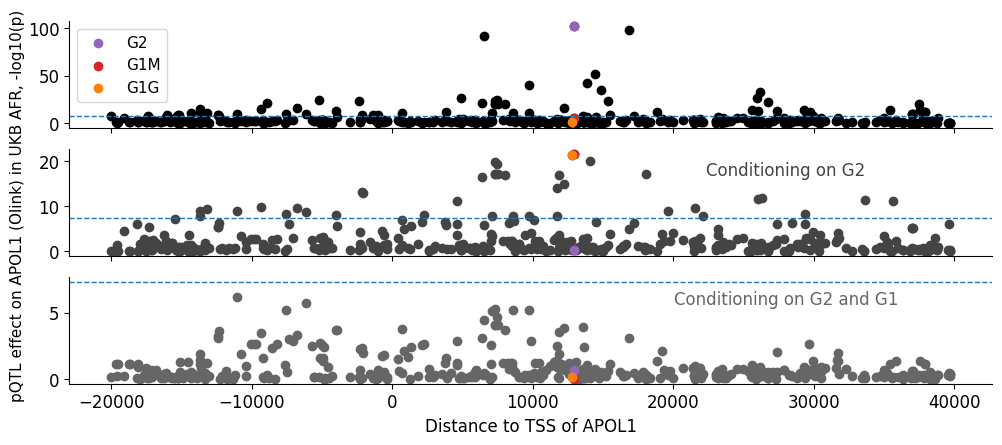

In [139]:
# Plot: 
ss = pd.read_parquet("apol1_genotype_nominal_n947.cis_qtl_pairs.chr22.parquet")
ssc1 = pd.read_parquet("apol1_genotype_g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc2 = pd.read_parquet("apol1_genotype_g1g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc25 = pd.read_parquet("apol1_genotype_g2v1adj_n947.cis_qtl_pairs.chr22.parquet")
ssc3 = pd.read_parquet("apol1_genotype_g1g2v1adj_n947.cis_qtl_pairs.chr22.parquet")


from matplotlib.cm import viridis
colors = ["#000000", "#444444", "#666666"]
ytextposs = [50, 18, 6]
texts = ["", "Conditioning on G2", "Conditioning on G2 and G1"]
sss = [ss[(-0.2*10**5<ss.start_distance)&(ss.start_distance<0.4*10**5)], ssc1[(-0.2*10**5<ssc1.start_distance)&(ssc1.start_distance<0.4*10**5)],
       ssc2[(-0.2*10**5<ssc2.start_distance)&(ssc2.start_distance<0.4*10**5)]]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,4.5), sharex=True, sharey=False)
for i in range(3):
    if i==0:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple", label="G2")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red", label="G1M")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange", label="G1G")    
    else:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange")
    ax[i].axhline(y=-np.log10(5*10**-8), linestyle="--", linewidth=1, color="tab:blue")
    ax[i].text(x=28000, y=ytextposs[i], s=texts[i], ha="center", va="center", color=colors[i])
#ax[0].set_title("title")
ax[2].set_xlabel("Distance to TSS of APOL1")
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
fig.text(0, 0.55, 'pQTL effect on APOL1 (Olink) in UKB AFR, -log10(p)', va='center', rotation='vertical', fontsize=11) #Shared y axis    
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].legend(fontsize=11, loc="upper left")
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("afr_manhattan_condition_main.png", dpi=500)
plt.savefig("afr_manhattan_condition_main.pdf", dpi=500)
plt.show()
plt.close()

6.800137413709447e-103


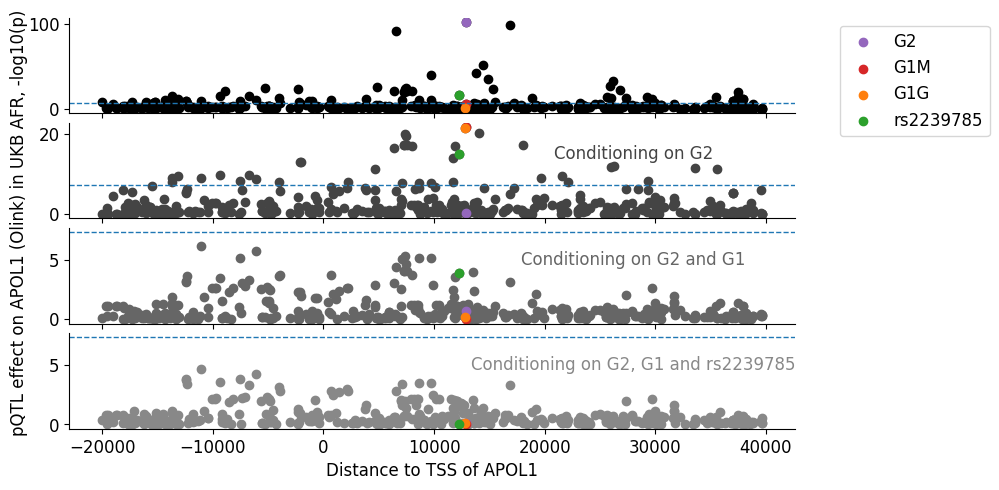

In [140]:
#Also same plot including V1:

#g12 = ["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"]
#g12names = ["G1M", "G1G", "G2", "V1"]

#Check manhattan:
ss = pd.read_parquet("apol1_genotype_nominal_n947.cis_qtl_pairs.chr22.parquet")
ssc1 = pd.read_parquet("apol1_genotype_g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc2 = pd.read_parquet("apol1_genotype_g1g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc25 = pd.read_parquet("apol1_genotype_g2v1adj_n947.cis_qtl_pairs.chr22.parquet")
ssc3 = pd.read_parquet("apol1_genotype_g1g2v1adj_n947.cis_qtl_pairs.chr22.parquet")
print (ss.pval_nominal.min()) #Make sure that it is not exact 0


from matplotlib.cm import viridis
colors = ["#000000", "#444444", "#666666", "#888888"]
ytextposs = [50, 15, 5, 5]
texts = ["", "Conditioning on G2", "Conditioning on G2 and G1", "Conditioning on G2, G1 and rs2239785"]
sss = [ss[(-0.2*10**5<ss.start_distance)&(ss.start_distance<0.4*10**5)], ssc1[(-0.2*10**5<ssc1.start_distance)&(ssc1.start_distance<0.4*10**5)],
       ssc2[(-0.2*10**5<ssc2.start_distance)&(ssc2.start_distance<0.4*10**5)], ssc3[(-0.2*10**5<ssc3.start_distance)&(ssc3.start_distance<0.4*10**5)]]
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,5), sharex=True, sharey=False)
for i in range(4):
    if i==0:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple", label="G2")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red", label="G1M")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange", label="G1G")    
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green", label="rs2239785")        
    else:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green")
    ax[i].axhline(y=-np.log10(5*10**-8), linestyle="--", linewidth=1, color="tab:blue")
    ax[i].text(x=28000, y=ytextposs[i], s=texts[i], ha="center", va="center", color=colors[i])
#ax[0].set_title("title")
ax[3].set_xlabel("Distance to TSS of APOL1")
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
fig.text(0, 0.55, 'pQTL effect on APOL1 (Olink) in UKB AFR, -log10(p)', va='center', rotation='vertical', fontsize=12) #Shared y axis    
ax[0].legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
plt.savefig("afr_manhattan_condition_genotypeonly.png", dpi=500)
plt.savefig("afr_manhattan_condition_genotypeonly.pdf", dpi=500)
plt.show()
plt.close()

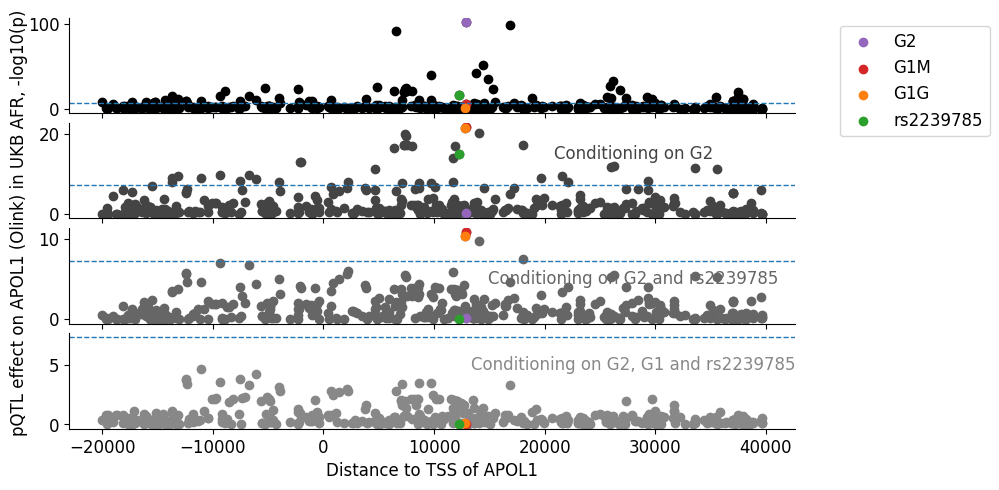

In [141]:
#Version where I condition on G1 first
colors = ["#000000", "#444444", "#666666", "#888888"]
ytextposs = [50, 15, 5, 5]
texts = ["", "Conditioning on G2", "Conditioning on G2 and rs2239785", "Conditioning on G2, G1 and rs2239785"]
sss = [ss[(-0.2*10**5<ss.start_distance)&(ss.start_distance<0.4*10**5)], ssc1[(-0.2*10**5<ssc1.start_distance)&(ssc1.start_distance<0.4*10**5)],
       ssc25[(-0.2*10**5<ssc25.start_distance)&(ssc25.start_distance<0.4*10**5)], ssc3[(-0.2*10**5<ssc3.start_distance)&(ssc3.start_distance<0.4*10**5)]]
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,5), sharex=True, sharey=False)
for i in range(4):
    if i==0:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple", label="G2")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red", label="G1M")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange", label="G1G")    
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green", label="rs2239785")        
    else:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green")
    ax[i].axhline(y=-np.log10(5*10**-8), linestyle="--", linewidth=1, color="tab:blue")
    ax[i].text(x=28000, y=ytextposs[i], s=texts[i], ha="center", va="center", color=colors[i])
#ax[0].set_title("title")
ax[3].set_xlabel("Distance to TSS of APOL1")
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
fig.text(0, 0.55, 'pQTL effect on APOL1 (Olink) in UKB AFR, -log10(p)', va='center', rotation='vertical', fontsize=12) #Shared y axis    
ax[0].legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
plt.savefig("afr_manhattan_condition_genotypeonly2.png", dpi=500)
plt.savefig("afr_manhattan_condition_genotypeonly2.pdf", dpi=500)
plt.show()
plt.close()

In [53]:
#Also perform fine-mapping:
cov = covariate_df
I = pd.DataFrame(np.identity(cov.shape[0]), cov.index, cov.index)
inside_invterm = cov.T@cov
invterm = pd.DataFrame(np.linalg.inv(inside_invterm.values), inside_invterm.columns, inside_invterm.index)
M = I - cov @ invterm @cov.T

#LD:
X = genotype_df.T.apply(lambda l: (l-l.mean())/l.std(), axis=0)
ld = pd.DataFrame(np.corrcoef(X.T))
X_adj = M@X
ld_adj = pd.DataFrame(np.corrcoef(X_adj.T))

outfn = "ppp_apol1_afr_genotype_ld_covadj_n947.ld"
ld_adj.to_csv(outfn, sep=" ", index=False, header=None)
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

#prep. for FINEMAP:
ss = pd.read_parquet("apol1_genotype_nominal_n947.cis_qtl_pairs.chr22.parquet")
ss["rsid"] = ss.variant_id
ss["chromosome"] = ss.variant_id.str.split(":").str[0]
ss["position"] = ss.variant_id.str.split(":").str[1].astype(int)
ss["allele1"] = ss.variant_id.str.split(":").str[2]
ss["allele2"] = ss.variant_id.str.split(":").str[3]
ss["maf"] = np.minimum(ss.af, 1-ss.af)
ss.rename(columns = {"slope":"beta", "slope_se":"se"}, inplace=True)
ss = ss[["rsid","chromosome","position","allele1","allele2","maf","beta","se"]]

outfn = "ppp_apol1_afr_genotype_n947_ss_for_fm.z"
ss.to_csv(outfn, sep=" ", index=False)
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

In [ ]:
#Run FM these in bash:
wget https://www.christianbenner.com/finemap_v1.4.2_x86_64.tgz
tar -xzf finemap_v1.4.2_x86_64.tgz
N=947
echo 'z;ld;snp;config;cred;log;n_samples' > ./master
zfn=ppp_apol1_afr_genotype_n947_ss_for_fm.z
ldfn=ppp_apol1_afr_genotype_ld_covadj_n947.ld
snpfn=apol1_ukb_afr_genotype_n947_cis.snp
config=apol1_ukb_afr_genotype_n947_cis.config
cred=apol1_ukb_afr_genotype_n947_cis.cred
log=apol1_ukb_afr_genotype_n947_cis.log
echo "$zfn;$ldfn;$snpfn;$config;$cred;$log;$N" >> ./master
#Run FINEMAP:
finemap_v1.4.2_x86_64/finemap_v1.4.2_x86_64 --n-causal-snps 10 --sss --in-files ./master

## genotype + exome hybrid (version 1)
Next we are going to replace the data with exome, for our variants of interest (i.e. G1, G2 and V1):

In [65]:
g12 = ["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"]
g12names = ["G1M", "G1G", "G2", "V1"]

fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.sample"
sns = pd.read_csv(fn, sep=" ")
sns = sns.iloc[1:,:].ID_1

fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.bgen"
bfile = BgenReader(fn)
exomes = []
for vname in g12:
    v = bfile.with_rsid(vname)[0]
    dos = pd.Series(v.alt_dosage)
    exomes.append(dos)

/tmp/ipykernel_219/2651154914.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sns = pd.read_csv(fn, sep=" ")


In [ ]:
exomes = pd.concat(exomes, axis=1)
exomes.index = sns
exomes.columns = ["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"]

In [ ]:
#Now try to replace the existing "genotype_df":
g1mdf = pd.DataFrame(genotype_df.loc["22:36265988:T:G",:]).join(exomes["22:36265988:T:G"], how="left", rsuffix="_exome")

In [69]:
g1mdf.value_counts()

22:36265988:T:G  22:36265988:T:G_exome
0.0              0.0                      453
1.0              1.0                      282
2.0              2.0                       81
                 1.0                       74
1.0              0.0                        3
Name: count, dtype: int64

In [ ]:
g1mdf["g1m_combined"] = g1mdf["22:36265988:T:G_exome"]
g1mdf.loc[g1mdf["22:36265988:T:G_exome"].isna(), "g1m_combined"] = g1mdf.loc[g1mdf["22:36265988:T:G_exome"].isna(), "22:36265988:T:G"]

In [73]:
#Prep. for tensorQTL:
genotype_df = dosages_g.copy(deep=True)
genotype_df.fillna(genotype_df.mean(axis=0), inplace=True)
genotype_df.index = genotype_df.index.astype(int)
ac = genotype_df.round(0).sum(axis=0) #mac>9 in hardcall
N = genotype_df.shape[0]*2
mac = np.minimum(ac, N-ac)
genotype_df = genotype_df.loc[:,mac>9].T
genotype_df.index.name = "ID"
variant_df = pd.DataFrame({"chrom":"chr"+genotype_df.index.str.split(":").str[0],"pos":genotype_df.index.str.split(":").str[1].astype(int)})
variant_df.index = genotype_df.index

genotype_df.loc["22:36265988:T:G",:] = g1mdf["g1m_combined"]

#Phenotype:
fn = "/mnt/project/qsw/resources/ppp_afr_expression_mat_naincluded.tsv.gz"
d = pd.read_csv(fn, sep="\t", index_col=0)
apol1 = d["OID30708"]
apol1.dropna(inplace=True)
phenotype_df = inverse_normal_transform(apol1.squeeze())
phenotype_df = pd.DataFrame(phenotype_df).T
phenotype_df.index.name = "gene_id"
phenotype_df.index = ["apol1"]
phenotype_df.columns.name = ""
phenotype_pos_df = pd.DataFrame({"gene_id":["apol1"],"chr":["chr22"], "pos":36253071}) #hg38
phenotype_pos_df.set_index("gene_id", inplace=True)

#Covariates use the previous one:
outfn = "/mnt/project/qsw/resources/covariate_matrix_afr_normed.tsv.gz"
covariate_df = pd.read_csv(outfn, sep="\t", compression="gzip", index_col=0).T
covariate_df.index.name="id"
covariate_df.index = covariate_df.index.astype(int)
covariate_df = covariate_df.loc[phenotype_df.columns,:] #Filter the ones APOL1 expression is missing

In [74]:
import subprocess
#Nominal:
out_prefix = "apol1_g1m_exome_nominal_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariate_df, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

#Adjusting for G2:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc["22:36265995:AATAATT:A",:].T], axis=1)
out_prefix = "apol1_g1m_exome_g2adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G"],:].T], axis=1)
out_prefix = "apol1_g1m_exome_g1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_g1m_exome_v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s and G2:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A"],:].T], axis=1)
out_prefix = "apol1_g1m_exome_g1g2adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_g1m_exome_g1v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G2 and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265995:AATAATT:A", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_g1m_exome_g2v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s, G2 and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_g1m_exome_g1g2v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 947 samples
  * 1 phenotypes
  * 17 covariates
  * 1861 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing output
done.
cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 947 samples
  * 1 phenotypes
  * 18 covariates
  * 1861 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing output
done.
cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 947 samples
  * 1 phenotypes
  * 19 covariates
  * 1861 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing outpu

6.800137413709447e-103
Changing G1M to exome, while keeping others as is


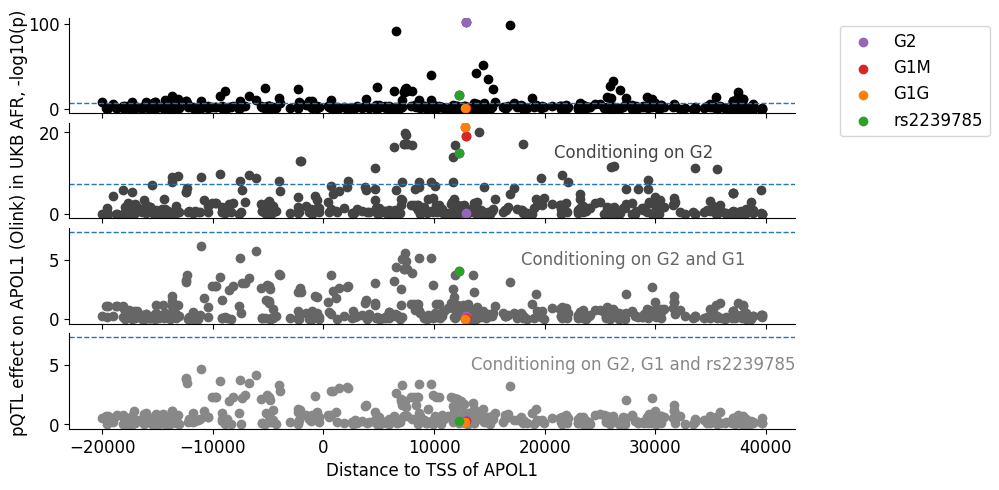

In [75]:
#Check manhattan:
ss = pd.read_parquet("apol1_g1m_exome_nominal_n947.cis_qtl_pairs.chr22.parquet")
ssc1 = pd.read_parquet("apol1_g1m_exome_g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc2 = pd.read_parquet("apol1_g1m_exome_g1g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc25 = pd.read_parquet("apol1_g1m_exome_g2v1adj_n947.cis_qtl_pairs.chr22.parquet")
ssc3 = pd.read_parquet("apol1_g1m_exome_g1g2v1adj_n947.cis_qtl_pairs.chr22.parquet")
print (ss.pval_nominal.min()) #Make sure that it is not exact 0

print ("Changing G1M to exome, while keeping others as is")

from matplotlib.cm import viridis
colors = ["#000000", "#444444", "#666666", "#888888"]
ytextposs = [50, 15, 5, 5]
texts = ["", "Conditioning on G2", "Conditioning on G2 and G1", "Conditioning on G2, G1 and rs2239785"]
sss = [ss[(-0.2*10**5<ss.start_distance)&(ss.start_distance<0.4*10**5)], ssc1[(-0.2*10**5<ssc1.start_distance)&(ssc1.start_distance<0.4*10**5)],
       ssc2[(-0.2*10**5<ssc2.start_distance)&(ssc2.start_distance<0.4*10**5)], ssc3[(-0.2*10**5<ssc3.start_distance)&(ssc3.start_distance<0.4*10**5)]]
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,5), sharex=True, sharey=False)
for i in range(4):
    if i==0:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple", label="G2")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red", label="G1M")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange", label="G1G")    
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green", label="rs2239785")        
    else:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green")
    ax[i].axhline(y=-np.log10(5*10**-8), linestyle="--", linewidth=1, color="tab:blue")
    ax[i].text(x=28000, y=ytextposs[i], s=texts[i], ha="center", va="center", color=colors[i])
#ax[0].set_title("title")
ax[3].set_xlabel("Distance to TSS of APOL1")
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
fig.text(0, 0.55, 'pQTL effect on APOL1 (Olink) in UKB AFR, -log10(p)', va='center', rotation='vertical', fontsize=12) #Shared y axis    
ax[0].legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
plt.savefig("afr_manhattan_condition_g1mexome.png", dpi=500)
plt.savefig("afr_manhattan_condition_g1mexome.pdf", dpi=500)
plt.show()
plt.close()

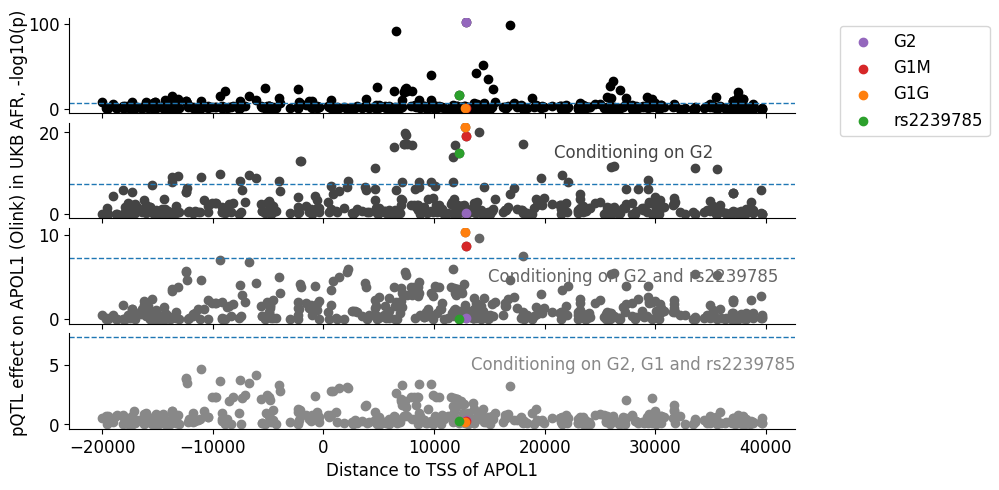

In [76]:
#Condition on G1 first
colors = ["#000000", "#444444", "#666666", "#888888"]
ytextposs = [50, 15, 5, 5]
texts = ["", "Conditioning on G2", "Conditioning on G2 and rs2239785", "Conditioning on G2, G1 and rs2239785"]
sss = [ss[(-0.2*10**5<ss.start_distance)&(ss.start_distance<0.4*10**5)], ssc1[(-0.2*10**5<ssc1.start_distance)&(ssc1.start_distance<0.4*10**5)],
       ssc25[(-0.2*10**5<ssc25.start_distance)&(ssc25.start_distance<0.4*10**5)], ssc3[(-0.2*10**5<ssc3.start_distance)&(ssc3.start_distance<0.4*10**5)]]
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,5), sharex=True, sharey=False)
for i in range(4):
    if i==0:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple", label="G2")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red", label="G1M")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange", label="G1G")    
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green", label="rs2239785")        
    else:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green")
    ax[i].axhline(y=-np.log10(5*10**-8), linestyle="--", linewidth=1, color="tab:blue")
    ax[i].text(x=28000, y=ytextposs[i], s=texts[i], ha="center", va="center", color=colors[i])
#ax[0].set_title("title")
ax[3].set_xlabel("Distance to TSS of APOL1")
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
fig.text(0, 0.55, 'pQTL effect on APOL1 (Olink) in UKB AFR, -log10(p)', va='center', rotation='vertical', fontsize=12) #Shared y axis    
ax[0].legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
plt.savefig("afr_manhattan_condition_g1mexome2.png", dpi=500)
plt.savefig("afr_manhattan_condition_g1mexome2.pdf", dpi=500)
plt.show()
plt.close()

## genotype + exome hybrid (version 2)
Next we are going to replace the data with exome, not only for G1, G2 and V1, but for all the variants existing in exome:
(We ended up using this result for the main manuscript)

In [88]:
fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.sample"
sns = pd.read_csv(fn, sep=" ")
sns = sns.iloc[1:,:].ID_1

samples_use = genotype_df.columns.intersection(sns)
fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.bgen"
bfile = BgenReader(fn)
exomes_full = []
vnames_list = []
cnt = 0
for vname in genotype_df.index:
    try:
        v = bfile.with_rsid(vname)[0]
        dos = pd.Series(v.alt_dosage)
        dos.index = sns
        exomes_full.append(dos[samples_use])
        vnames_list.append(vname)
    except:
        pass
    if cnt%100==0:
        print (cnt)
        print (tm.ctime())
    cnt += 1
    
exomes_full = pd.concat(exomes_full, axis=1)
exomes_full.columns = vnames_list

In [92]:
#Prep. for tensorQTL:
genotype_df = dosages_g.copy(deep=True)
genotype_df.fillna(genotype_df.mean(axis=0), inplace=True)
genotype_df.index = genotype_df.index.astype(int)
ac = genotype_df.round(0).sum(axis=0) #mac>9 in hardcall
N = genotype_df.shape[0]*2
mac = np.minimum(ac, N-ac)
genotype_df = genotype_df.loc[:,mac>9].T
genotype_df.index.name = "ID"
variant_df = pd.DataFrame({"chrom":"chr"+genotype_df.index.str.split(":").str[0],"pos":genotype_df.index.str.split(":").str[1].astype(int)})
variant_df.index = genotype_df.index

#Replace with exome when not NA:
genotype_df_original = genotype_df.copy(deep=True)
#First fill by exome, allowing NAs
for col in exomes_full.columns:
    genotype_df.loc[col,exomes_full.index] = exomes_full[col]
#Then fill the NAs back with the original data:
genotype_df.fillna(genotype_df_original, inplace=True)

#Phenotype:
fn = "/mnt/project/qsw/resources/ppp_afr_expression_mat_naincluded.tsv.gz"
d = pd.read_csv(fn, sep="\t", index_col=0)
apol1 = d["OID30708"]
apol1.dropna(inplace=True)
phenotype_df = inverse_normal_transform(apol1.squeeze())
phenotype_df = pd.DataFrame(phenotype_df).T
phenotype_df.index.name = "gene_id"
phenotype_df.index = ["apol1"]
phenotype_df.columns.name = ""
phenotype_pos_df = pd.DataFrame({"gene_id":["apol1"],"chr":["chr22"], "pos":36253071}) #hg38
phenotype_pos_df.set_index("gene_id", inplace=True)

#Covariates use the previous one:
outfn = "/mnt/project/qsw/resources/covariate_matrix_afr_normed.tsv.gz"
covariate_df = pd.read_csv(outfn, sep="\t", compression="gzip", index_col=0).T
covariate_df.index.name="id"
covariate_df.index = covariate_df.index.astype(int)
covariate_df = covariate_df.loc[phenotype_df.columns,:] #Filter the ones APOL1 expression is missing#Now substitute all the existing variants:


In [100]:
#TensorQTL:
#Nominal:
out_prefix = "apol1_geno_ex_hybrid_nominal_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariate_df, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

#Adjusting for G2:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc["22:36265995:AATAATT:A",:].T], axis=1)
out_prefix = "apol1_geno_ex_hybrid_g2adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G"],:].T], axis=1)
out_prefix = "apol1_geno_ex_hybrid_g1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_geno_ex_hybrid_v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s and G2:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A"],:].T], axis=1)
out_prefix = "apol1_geno_ex_hybrid_g1g2adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_geno_ex_hybrid_g1v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G2 and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265995:AATAATT:A", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_geno_ex_hybrid_g2v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s, G2 and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_geno_ex_hybrid_g1g2v1adj_n947"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 947 samples
  * 1 phenotypes
  * 17 covariates
  * 1861 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing output
done.
cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 947 samples
  * 1 phenotypes
  * 18 covariates
  * 1861 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing output
done.
cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 947 samples
  * 1 phenotypes
  * 19 covariates
  * 1861 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing outpu

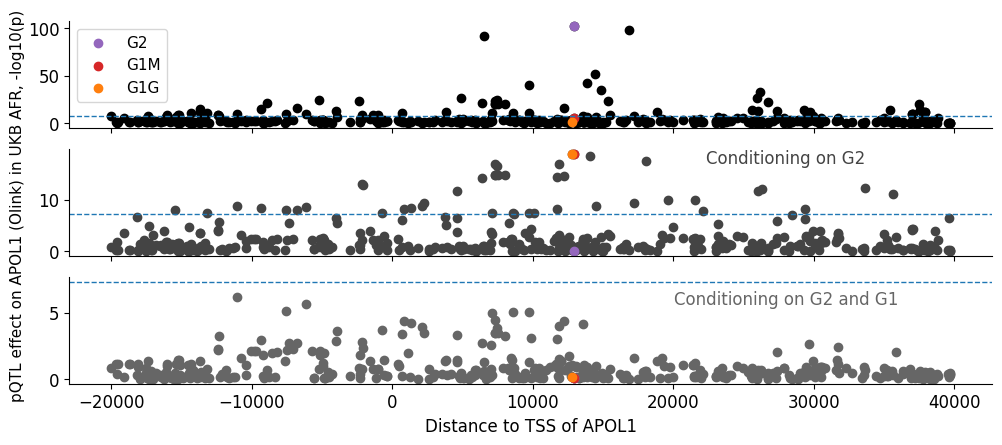

In [142]:
#Main figure; don't even need V1:
ssc1 = pd.read_parquet("apol1_geno_ex_hybrid_g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc2 = pd.read_parquet("apol1_geno_ex_hybrid_g1g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc25 = pd.read_parquet("apol1_geno_ex_hybrid_g2v1adj_n947.cis_qtl_pairs.chr22.parquet")
ssc3 = pd.read_parquet("apol1_geno_ex_hybrid_g1g2v1adj_n947.cis_qtl_pairs.chr22.parquet")


from matplotlib.cm import viridis
colors = ["#000000", "#444444", "#666666"]
ytextposs = [50, 18, 6]
texts = ["", "Conditioning on G2", "Conditioning on G2 and G1"]
sss = [ss[(-0.2*10**5<ss.start_distance)&(ss.start_distance<0.4*10**5)], ssc1[(-0.2*10**5<ssc1.start_distance)&(ssc1.start_distance<0.4*10**5)],
       ssc2[(-0.2*10**5<ssc2.start_distance)&(ssc2.start_distance<0.4*10**5)]]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,4.5), sharex=True, sharey=False)
for i in range(3):
    if i==0:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple", label="G2")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red", label="G1M")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange", label="G1G")    
    else:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange")
    ax[i].axhline(y=-np.log10(5*10**-8), linestyle="--", linewidth=1, color="tab:blue")
    ax[i].text(x=28000, y=ytextposs[i], s=texts[i], ha="center", va="center", color=colors[i])
#ax[0].set_title("title")
ax[2].set_xlabel("Distance to TSS of APOL1")
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
fig.text(0, 0.55, 'pQTL effect on APOL1 (Olink) in UKB AFR, -log10(p)', va='center', rotation='vertical', fontsize=11) #Shared y axis    
#ax[0].legend(bbox_to_anchor=(1.05,1))
ax[0].legend(fontsize=11, loc="upper left")
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("afr_manhattan_condition_hybrid_main.png", dpi=500)
plt.savefig("afr_manhattan_condition_hybrid_main.pdf", dpi=500)
plt.show()
plt.close()

2.896892638649178e-122
Replacing by exome when possible


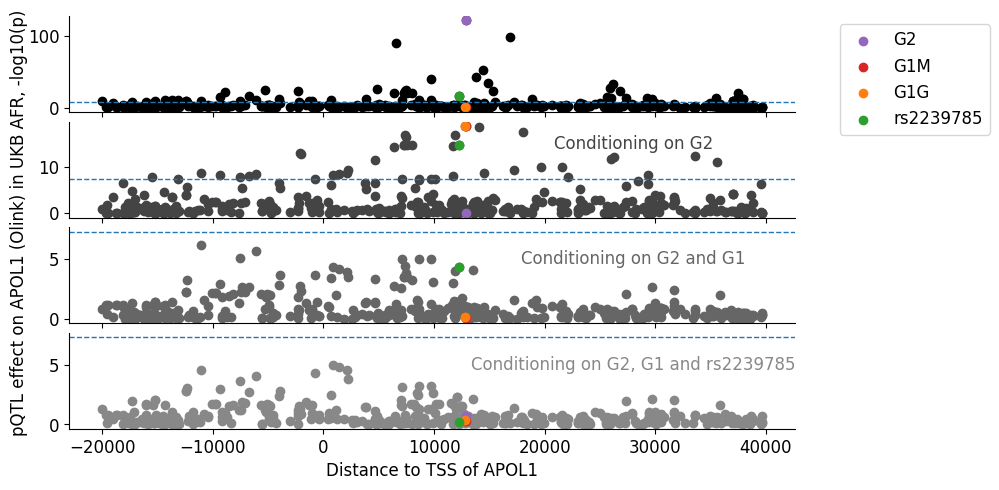

In [101]:
#Check manhattan:
ss = pd.read_parquet("apol1_geno_ex_hybrid_nominal_n947.cis_qtl_pairs.chr22.parquet")
ssc1 = pd.read_parquet("apol1_geno_ex_hybrid_g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc2 = pd.read_parquet("apol1_geno_ex_hybrid_g1g2adj_n947.cis_qtl_pairs.chr22.parquet")
ssc25 = pd.read_parquet("apol1_geno_ex_hybrid_g2v1adj_n947.cis_qtl_pairs.chr22.parquet")
ssc3 = pd.read_parquet("apol1_geno_ex_hybrid_g1g2v1adj_n947.cis_qtl_pairs.chr22.parquet")
print (ss.pval_nominal.min()) #Make sure that it is not exact 0
print ("Replacing by exome when possible")

from matplotlib.cm import viridis
colors = ["#000000", "#444444", "#666666", "#888888"]
ytextposs = [50, 15, 5, 5]
texts = ["", "Conditioning on G2", "Conditioning on G2 and G1", "Conditioning on G2, G1 and rs2239785"]
sss = [ss[(-0.2*10**5<ss.start_distance)&(ss.start_distance<0.4*10**5)], ssc1[(-0.2*10**5<ssc1.start_distance)&(ssc1.start_distance<0.4*10**5)],
       ssc2[(-0.2*10**5<ssc2.start_distance)&(ssc2.start_distance<0.4*10**5)], ssc3[(-0.2*10**5<ssc3.start_distance)&(ssc3.start_distance<0.4*10**5)]]
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,5), sharex=True, sharey=False)
for i in range(4):
    if i==0:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple", label="G2")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red", label="G1M")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange", label="G1G")    
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green", label="rs2239785")        
    else:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green")
    ax[i].axhline(y=-np.log10(5*10**-8), linestyle="--", linewidth=1, color="tab:blue")
    ax[i].text(x=28000, y=ytextposs[i], s=texts[i], ha="center", va="center", color=colors[i])
#ax[0].set_title("title")
ax[3].set_xlabel("Distance to TSS of APOL1")
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
fig.text(0, 0.55, 'pQTL effect on APOL1 (Olink) in UKB AFR, -log10(p)', va='center', rotation='vertical', fontsize=12) #Shared y axis    
ax[0].legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
plt.savefig("afr_manhattan_condition_geno_ex_hybrid_.png", dpi=500)
plt.savefig("afr_manhattan_condition_geno_ex_hybrid_.pdf", dpi=500)
plt.show()
plt.close()

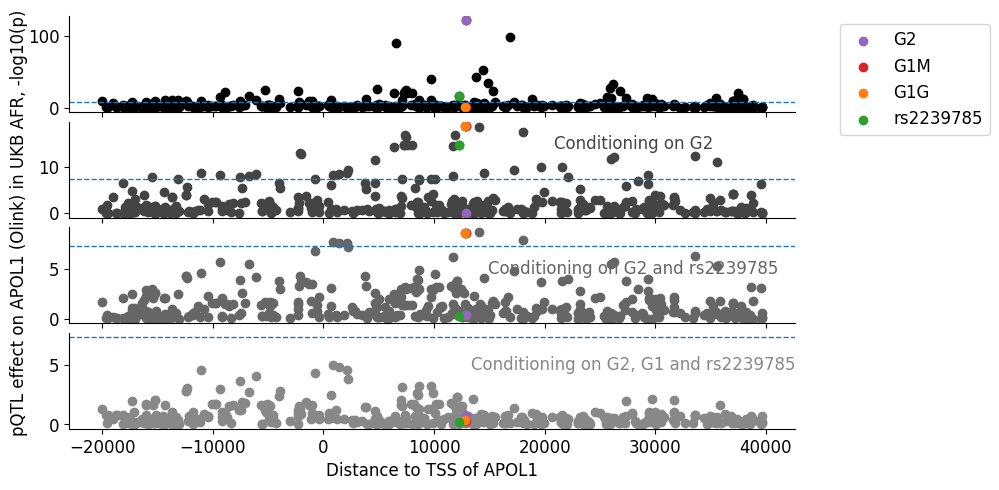

In [102]:
colors = ["#000000", "#444444", "#666666", "#888888"]
ytextposs = [50, 15, 5, 5]
texts = ["", "Conditioning on G2", "Conditioning on G2 and rs2239785", "Conditioning on G2, G1 and rs2239785"]
sss = [ss[(-0.2*10**5<ss.start_distance)&(ss.start_distance<0.4*10**5)], ssc1[(-0.2*10**5<ssc1.start_distance)&(ssc1.start_distance<0.4*10**5)],
       ssc25[(-0.2*10**5<ssc25.start_distance)&(ssc25.start_distance<0.4*10**5)], ssc3[(-0.2*10**5<ssc3.start_distance)&(ssc3.start_distance<0.4*10**5)]]
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,5), sharex=True, sharey=False)
for i in range(4):
    if i==0:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple", label="G2")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red", label="G1M")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange", label="G1G")    
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green", label="rs2239785")        
    else:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green")
    ax[i].axhline(y=-np.log10(5*10**-8), linestyle="--", linewidth=1, color="tab:blue")
    ax[i].text(x=28000, y=ytextposs[i], s=texts[i], ha="center", va="center", color=colors[i])
#ax[0].set_title("title")
ax[3].set_xlabel("Distance to TSS of APOL1")
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
fig.text(0, 0.55, 'pQTL effect on APOL1 (Olink) in UKB AFR, -log10(p)', va='center', rotation='vertical', fontsize=12) #Shared y axis    
ax[0].legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
plt.savefig("afr_manhattan_condition_geno_ex_hybrid_2.png", dpi=500)
plt.savefig("afr_manhattan_condition_geno_ex_hybrid_2.pdf", dpi=500)
plt.show()
plt.close()

In [103]:
#fine-mapping in FINEMAP:
cov = covariate_df
I = pd.DataFrame(np.identity(cov.shape[0]), cov.index, cov.index)
inside_invterm = cov.T@cov
invterm = pd.DataFrame(np.linalg.inv(inside_invterm.values), inside_invterm.columns, inside_invterm.index)
M = I - cov @ invterm @cov.T

#LD:
X = genotype_df.T.apply(lambda l: (l-l.mean())/l.std(), axis=0)
ld = pd.DataFrame(np.corrcoef(X.T))
X_adj = M@X
ld_adj = pd.DataFrame(np.corrcoef(X_adj.T))

outfn = "ppp_apol1_afr_geno_ex_hybrid_ld_covadj_n947.ld"
ld_adj.to_csv(outfn, sep=" ", index=False, header=None)
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

#prep. for FINEMAP:
ss = pd.read_parquet("apol1_geno_ex_hybrid_nominal_n947.cis_qtl_pairs.chr22.parquet")
ss["rsid"] = ss.variant_id
ss["chromosome"] = ss.variant_id.str.split(":").str[0]
ss["position"] = ss.variant_id.str.split(":").str[1].astype(int)
ss["allele1"] = ss.variant_id.str.split(":").str[2]
ss["allele2"] = ss.variant_id.str.split(":").str[3]
ss["maf"] = np.minimum(ss.af, 1-ss.af)
ss.rename(columns = {"slope":"beta", "slope_se":"se"}, inplace=True)
ss = ss[["rsid","chromosome","position","allele1","allele2","maf","beta","se"]]

outfn = "ppp_apol1_afr_geno_ex_hybrid_n947_ss_for_fm.z"
ss.to_csv(outfn, sep=" ", index=False)
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)#Let this be the final version probably?


In [ ]:
#Run FM these in bash:
wget https://www.christianbenner.com/finemap_v1.4.2_x86_64.tgz
tar -xzf finemap_v1.4.2_x86_64.tgz
N=947
echo 'z;ld;snp;config;cred;log;n_samples' > ./master
zfn=ppp_apol1_afr_geno_ex_hybrid_n947_ss_for_fm.z
ldfn=ppp_apol1_afr_geno_ex_hybrid_ld_covadj_n947.ld
snpfn=apol1_ukb_afr_geno_ex_hybrid_n947_cis.snp
config=apol1_ukb_afr_geno_ex_hybrid_n947_cis.config
cred=apol1_ukb_afr_geno_ex_hybrid_n947_cis.cred
log=apol1_ukb_afr_geno_ex_hybrid_n947_cis.log
echo "$zfn;$ldfn;$snpfn;$config;$cred;$log;$N" >> ./master
#Run FINEMAP:
finemap_v1.4.2_x86_64/finemap_v1.4.2_x86_64 --n-causal-snps 10 --sss --in-files ./master

In [ ]:
#Check:
fm = pd.read_csv("apol1_ukb_afr_geno_ex_hybrid_n947_cis.snp", sep=" ")
display(fm.head(20))
fm.set_index("rsid", inplace=True)
g12names = ["G1M", "G1G", "G2", "V1"]
g12 = ["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"]
dfg = fm.loc[g12, :]
dfg.index = g12names
#display(dfg) #REDACTED

In [ ]:
#in R: 
"""this in R
install.packages("susieR")
install.packages("data.table")

library(susieR)
library(data.table)
args = commandArgs(trailingOnly=TRUE)
ld = "ppp_apol1_afr_geno_ex_hybrid_ld_covadj_n947.ld"
z = "ppp_apol1_afr_geno_ex_hybrid_n947_ss_for_fm.z"
cs_out = "ppp_apol1_afr_geno_ex_hybrid_susie_cs.tsv"
pip_out = "ppp_apol1_afr_geno_ex_hybrid_susie_pip.tsv"
alpha_out = "ppp_apol1_afr_geno_ex_hybrid_susie_alpha.tsv"
n = 947

R = as.matrix(fread(ld))
print ("done reading ld in R")
print (Sys.time())
st = read.table(z, header=T)
st$z = st$beta / st$se

z_scores = st$z
print ("Starting SuSiE")
print (Sys.time())
fitted_rss = susie_rss(z_scores, R, n=n, L=10, refine=T, estimate_residual_variance = TRUE, max_iter = 1000)
print ("Done SuSiE, starting writing results")
print (Sys.time())
#write the results
write.table(summary(fitted_rss)$cs , cs_out, quote=F, sep='\t')
st$pip = fitted_rss$pip
write.table(st[c("rsid","pip")], pip_out, quote=F, sep='\t')
write.table(fitted_rss$alpha, alpha_out, quote=F, sep='\t')
print ("Done writing")
print (Sys.time())
"""

In [144]:
#Check:
#cs_out = "ppp_apol1_afr_geno_ex_hybrid_susie_cs.tsv"
pip_out = "ppp_apol1_afr_geno_ex_hybrid_susie_pip.tsv"
sus = pd.read_csv(pip_out, sep="\t")
sus.set_index("rsid", inplace=True)
display(sus.sort_values(by="pip", ascending=False).head(20))
g12 = ["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"]
g12names = ["G1M", "G1G", "G2", "V1"]
display(sus.loc[g12,:])

,pip
rsid,
22:36265995:AATAATT:A,1.000000
22:36242016:G:A,0.555468
22:36265988:T:G,0.442472
22:36265860:A:G,0.320067
22:36267167:T:C,0.206491
22:36246929:C:T,0.194518
22:36245510:C:T,0.056643
22:36261694:G:A,0.049781
22:36262819:T:G,0.049637


,pip
rsid,
22:36265988:T:G,0.442472
22:36265860:A:G,0.320067
22:36265995:AATAATT:A,1.000000
22:36265284:G:A,0.006869


## Exome-only version
We also did association test + visualization in exome-only data, just to see things are consistent:

In [110]:
#Do the exome full 893 samples:
fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.sample"
sns = pd.read_csv(fn, sep=" ")
sns = sns.iloc[1:,:].ID_1
samples_use = genotype_df.columns.intersection(sns)
fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.bgen"
bfile = BgenReader(fn)
left = 36253071 - 10**5
right = 36267530 + 10**5
variants = bfile.fetch('22', left, right)
exomes_full = []
cisvars = []
cnt = 0
for v in variants:
    dos = pd.Series(v.alt_dosage)
    dos.index = sns
    dos = dos[samples_use]
    if sum(dos[~dos.isna()])>4:
        cisvars.append(v.varid)
        exomes_full.append(dos)
    if cnt%500==0:
        print ("done {0} {1}".format(cnt, tm.ctime()))
    cnt += 1
exomes_full = pd.concat(exomes_full, axis=1)
exomes_full.columns = cisvars

/tmp/ipykernel_219/4056085554.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sns = pd.read_csv(fn, sep=" ")


done 0 Thu Sep 19 23:20:23 2024
done 500 Thu Sep 19 23:20:27 2024
done 1000 Thu Sep 19 23:20:31 2024
done 1500 Thu Sep 19 23:20:38 2024
done 2000 Thu Sep 19 23:20:41 2024
done 2500 Thu Sep 19 23:20:45 2024
done 3000 Thu Sep 19 23:20:49 2024
done 3500 Thu Sep 19 23:20:53 2024
done 4000 Thu Sep 19 23:20:57 2024
done 4500 Thu Sep 19 23:21:00 2024
done 5000 Thu Sep 19 23:21:04 2024
done 5500 Thu Sep 19 23:21:08 2024
done 6000 Thu Sep 19 23:21:12 2024
done 6500 Thu Sep 19 23:21:16 2024
done 7000 Thu Sep 19 23:21:19 2024
done 7500 Thu Sep 19 23:21:23 2024
done 8000 Thu Sep 19 23:21:27 2024
done 8500 Thu Sep 19 23:21:31 2024


In [ ]:
#exomes_full #Full exome in the APOL1 cis region - REDACTED

In [114]:
#Prep. for tensorQTL:
genotype_df = exomes_full.copy(deep=True)
genotype_df.fillna(genotype_df.mean(axis=0), inplace=True)
genotype_df.index = genotype_df.index.astype(int)
ac = genotype_df.round(0).sum(axis=0) #mac>9 in hardcall
N = genotype_df.shape[0]*2
mac = np.minimum(ac, N-ac)
genotype_df = genotype_df.loc[:,mac>9].T
genotype_df.index.name = "ID"
variant_df = pd.DataFrame({"chrom":"chr"+genotype_df.index.str.split(":").str[0],"pos":genotype_df.index.str.split(":").str[1].astype(int)})
variant_df.index = genotype_df.index

#Phenotype:
fn = "/mnt/project/qsw/resources/ppp_afr_expression_mat_naincluded.tsv.gz"
d = pd.read_csv(fn, sep="\t", index_col=0)
apol1 = d.loc[genotype_df.columns,"OID30708"]
apol1.dropna(inplace=True)
phenotype_df = inverse_normal_transform(apol1.squeeze())
phenotype_df = pd.DataFrame(phenotype_df).T
phenotype_df.index.name = "gene_id"
phenotype_df.index = ["apol1"]
phenotype_df.columns.name = ""
phenotype_pos_df = pd.DataFrame({"gene_id":["apol1"],"chr":["chr22"], "pos":36253071}) #hg38
phenotype_pos_df.set_index("gene_id", inplace=True)

#Covariates use the previous one:
outfn = "/mnt/project/qsw/resources/covariate_matrix_afr_normed.tsv.gz"
covariate_df = pd.read_csv(outfn, sep="\t", compression="gzip", index_col=0).T
covariate_df.index.name="id"
covariate_df.index = covariate_df.index.astype(int)
covariate_df = covariate_df.loc[phenotype_df.columns,:] #Filter the ones APOL1 expression is missing#With this re-organize phenotype and covariate df:

In [117]:
#TensorQTL:
#Nominal:
out_prefix = "apol1_exome_only_nominal_n893"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariate_df, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

#Adjusting for G2:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc["22:36265995:AATAATT:A",:].T], axis=1)
out_prefix = "apol1_exome_only_g2adj_n893"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G"],:].T], axis=1)
out_prefix = "apol1_exome_only_g1adj_n893"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_exome_only_v1adj_n893"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s and G2:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A"],:].T], axis=1)
out_prefix = "apol1_exome_only_g1g2adj_n893"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_exome_only_g1v1adj_n893"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G2 and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265995:AATAATT:A", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_exome_only_g2v1adj_n893"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)


#Adjusting for G1s, G2 and V1:
covariates_df_updated = pd.concat([covariate_df,genotype_df.loc[["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"],:].T], axis=1)
out_prefix = "apol1_exome_only_g1g2v1adj_n893"
testqtl = cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, window=10**8, maf_threshold=0,
                          covariates_df=covariates_df_updated, prefix=out_prefix)
outfn = out_prefix+".cis_qtl_pairs.chr22.parquet"
uploaded = subprocess.run(['dx', 'upload', "/opt/notebooks/{0}".format(outfn), "--path", "qsw/tmp_data/{0}".format(outfn)], capture_output=True, text=True)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 893 samples
  * 1 phenotypes
  * 17 covariates
  * 188 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing output
done.
cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 893 samples
  * 1 phenotypes
  * 18 covariates
  * 188 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing output
done.
cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 893 samples
  * 1 phenotypes
  * 19 covariates
  * 188 variants
  * cis-window: ±100,000,000
  * checking phenotypes: 1/1
  * Computing associations
    Mapping chromosome chr22
    processing phenotype 1/1
    time elapsed: 0.00 min
    * writing output
d

6.012009430604392e-114


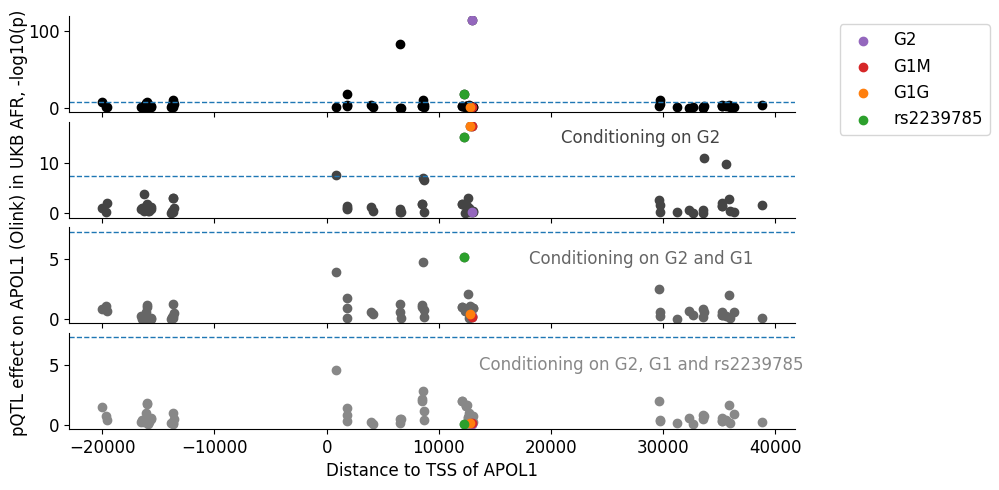

In [119]:
#Check manhattan:
ss = pd.read_parquet("apol1_exome_only_nominal_n893.cis_qtl_pairs.chr22.parquet")
ssc1 = pd.read_parquet("apol1_exome_only_g2adj_n893.cis_qtl_pairs.chr22.parquet")
ssc2 = pd.read_parquet("apol1_exome_only_g1g2adj_n893.cis_qtl_pairs.chr22.parquet")
ssc25 = pd.read_parquet("apol1_exome_only_g2v1adj_n893.cis_qtl_pairs.chr22.parquet")
ssc3 = pd.read_parquet("apol1_exome_only_g1g2v1adj_n893.cis_qtl_pairs.chr22.parquet")
print (ss.pval_nominal.min()) #Make sure that it is not exact 0


from matplotlib.cm import viridis
colors = ["#000000", "#444444", "#666666", "#888888"]
ytextposs = [50, 15, 5, 5]
texts = ["", "Conditioning on G2", "Conditioning on G2 and G1", "Conditioning on G2, G1 and rs2239785"]
sss = [ss[(-0.2*10**5<ss.start_distance)&(ss.start_distance<0.4*10**5)], ssc1[(-0.2*10**5<ssc1.start_distance)&(ssc1.start_distance<0.4*10**5)],
       ssc2[(-0.2*10**5<ssc2.start_distance)&(ssc2.start_distance<0.4*10**5)], ssc3[(-0.2*10**5<ssc3.start_distance)&(ssc3.start_distance<0.4*10**5)]]
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,5), sharex=True, sharey=False)
for i in range(4):
    if i==0:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple", label="G2")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red", label="G1M")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange", label="G1G")    
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green", label="rs2239785")        
    else:
        ax[i].scatter(sss[i].start_distance, -np.log10(sss[i].pval_nominal), color=colors[i])
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265995:AATAATT:A"].pval_nominal), color="tab:purple")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265988:T:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265988:T:G"].pval_nominal), color="tab:red")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265860:A:G"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265860:A:G"].pval_nominal), color="tab:orange")
        ax[i].scatter(sss[i][sss[i].variant_id=="22:36265284:G:A"].start_distance, 
                      -np.log10(sss[i][sss[i].variant_id=="22:36265284:G:A"].pval_nominal), color="tab:green")
    ax[i].axhline(y=-np.log10(5*10**-8), linestyle="--", linewidth=1, color="tab:blue")
    ax[i].text(x=28000, y=ytextposs[i], s=texts[i], ha="center", va="center", color=colors[i])
#ax[0].set_title("title")
ax[3].set_xlabel("Distance to TSS of APOL1")
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
fig.text(0, 0.55, 'pQTL effect on APOL1 (Olink) in UKB AFR, -log10(p)', va='center', rotation='vertical', fontsize=12) #Shared y axis    
ax[0].legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
fig.subplots_adjust(hspace=0.1)
plt.savefig("afr_manhattan_condition_exome_only.png", dpi=500)
plt.savefig("afr_manhattan_condition_exome_only.pdf", dpi=500)
plt.show()
plt.close()

In [ ]:
#fine-mapping: NA, as we are missing tons of non-coding variants anyways in exome data.